In [1]:
import torch
import gymnasium as gym
from broken_joint import BrokenJointEnv
from util import *

In [3]:
env_name = 'Hopper-v2'
source_env = BrokenJointEnv(gym.make(env_name), [])
target_env = BrokenJointEnv(gym.make(env_name), [1])   

/home/nomushroom/anaconda3/envs/rl/lib/python3.9/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/home/nomushroom/anaconda3/envs/rl/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_env.py:185: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [6]:
state, _ = source_env.reset()
print(state)


[ 1.25342810e+00 -4.42187087e-03 -3.54292377e-05  4.20697225e-03
  2.98334015e-04  1.42222380e-03  4.44221545e-04 -1.61088260e-03
  1.55046297e-03  7.69534946e-04 -8.03929195e-04]


In [10]:
state_dim = source_env.observation_space.shape[0]
print(state_dim)
running_mean = ZFilter((state_dim,), clip=5)
print(running_mean)
new_state = running_mean(state)
print(new_state)

11
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
action = source_env.action_space.sample()
next_state, reward, done, truncated, _ = source_env.step(action)
print(next_state)
next_state = running_mean(next_state)
print(next_state)

[ 1.25326593e+00 -7.91969668e-03 -1.81566948e-03  2.98328622e-04
 -4.43221821e-03 -1.37067687e-01 -4.14996616e-02 -8.72196473e-01
 -4.46144758e-01 -9.76914195e-01 -1.18056303e+00]
[-0.70704512 -0.70710392 -0.70710116 -0.70710422 -0.70710467 -0.70710671
 -0.70710654 -0.70710677 -0.70710676 -0.70710677 -0.70710677]


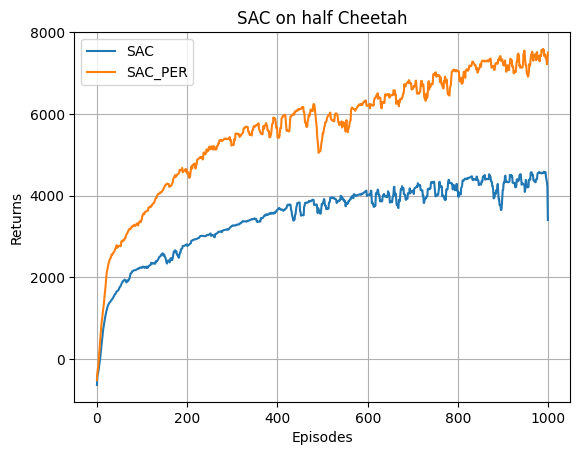

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import util

return_list = ['1', '2', '3', '4', '5']
SAC, SAC_per = [], []
for i in return_list:
    SAC.append(np.load('saved_data/reward_return/halfCheetah_{}.npy'.format(i)))
    SAC_per.append(np.load('saved_data/reward_return/halfCheetah_per_{}.npy'.format(i)))
    
SAC = np.array(SAC).mean(axis=0)
SAC_per = np.array(SAC_per).mean(axis=0)


smooth_return = util.smooth_figure(SAC, 9)
smooth_return_per = util.smooth_figure(SAC_per, 9)
episodes_list = list(range(len(smooth_return)))
plt.plot(episodes_list, smooth_return)
plt.plot(episodes_list, smooth_return_per)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on half Cheetah')
plt.legend(['SAC', 'SAC_PER'])
plt.grid()
plt.show()


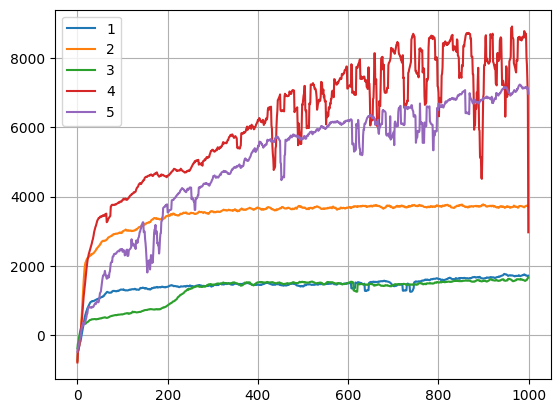

In [6]:
# plot each episode
return_list = ['1', '2', '3', '4', '5']
SAC, SAC_per = [], []
for i in return_list:
    SAC.append(np.load('saved_data/reward_return/halfCheetah_{}.npy'.format(i)))
    SAC_per.append(np.load('saved_data/reward_return/halfCheetah_per_{}.npy'.format(i)))
    
for i in range(5):
    plt.plot(episodes_list, util.smooth_figure(SAC[i], 9))
plt.grid()
plt.legend(['1', '2', '3', '4', '5'])

In [2]:
import numpy as np


a = np.array([1, 2, 3])
print(a[np.newaxis, :])

[[1 2 3]]


In [3]:
c

NameError: name 'c' is not defined